<a href="https://colab.research.google.com/github/presentchris/Computer-Vision/blob/main/TrayInspectionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###이미지 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/CountTrayImg'

Mounted at /content/drive


###라이브러리 모음

In [3]:
from PIL import Image
import os
import cv2
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

###전처리 부분

In [4]:
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(folder_path, filename)
        with Image.open(image_path) as img:
            img_cropped = img.crop((800, 700, 4700, 3380))
            img_resized = img_cropped.resize((250, 250))
            img_gray = img_resized.convert('L')

            img_gray.save(f'/content/drive/My Drive/NewCountTrayImg/{filename}')

print("완료")


완료


###뒷부분에 적용은 안 되지만 OpenCV를 사용한 Threshold, Contours 테스트

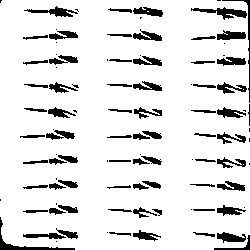

In [5]:
ima = cv2.imread('/content/drive/My Drive/NewCountTrayImg/372.jpg', cv2.IMREAD_GRAYSCALE)

_, binary_image = cv2.threshold(ima, 55, 255, cv2.THRESH_BINARY)

cv2_imshow(binary_image)

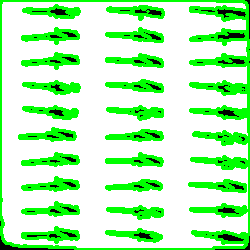

In [6]:
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

color_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

cv2.drawContours(color_image, contours, -1, (0, 255, 0), 2)

cv2_imshow(color_image)

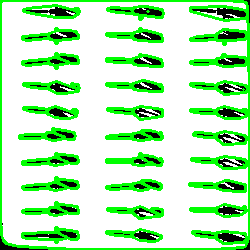

볼록 껍질의 갯수 : 104


In [7]:
# 윤곽선을 볼록 껍질로 변환
hulls = [cv2.convexHull(cnt) for cnt in contours]

# 윤곽선 그리기
color_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
for hull in hulls:
    cv2.drawContours(color_image, [hull], -1, (0, 255, 0), 2)

# 결과 표시
cv2_imshow(color_image)

# 볼록 껍질의 갯수 출력
print("볼록 껍질의 갯수 :", len(hulls)-1)

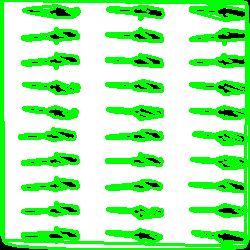

갯수 : 32.5


In [8]:
# 각 윤곽선을 근사화하고 그리기
for cnt in contours:
    epsilon = 0.01 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    cv2.drawContours(color_image, [approx], -1, (0, 255, 0), 2)

# 결과 표시
cv2_imshow(color_image)

print(f'갯수 : {len(cnt)/2-1}')

###YOLOv8 Setup

In [9]:
# %pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.8/107.7 GB disk)


###Predict Test

In [10]:
# !yolo predict model=yolov8n.pt source= '/content/drive/My Drive/yolov8n.pt'

100% 6.23M/6.23M [00:00<00:00, 128MB/s]
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 582, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 452, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/predictor.py", line 177, in predict_cli
    for _ in gen:  # noqa, running CLI inference without accumulating any outputs (do not modify)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 35, in generator_

###Val

In [11]:
import torch
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')
# !unzip -q tmp.zip -d datasets && rm tmp.zip  # unzip

100%|██████████| 780M/780M [00:06<00:00, 122MB/s]


In [12]:
# !yolo val model=yolov8n.pt data=coco8.yaml

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

Dataset 'coco8.yaml' images not found ⚠️, missing path '/content/datasets/coco8/images/val'
100% 433k/433k [00:00<00:00, 53.5MB/s]
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100% 25/25 [00:00<00:00, 2651.47file/s]
Dataset download success ✅ (0.6s), saved to /content/datasets

100% 755k/755k [00:00<00:00, 88.0MB/s]
val: Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100% 4/4 [00:00<00:00, 154.75it/s]
val: New cache created: /content/datasets/coco8/labels/val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:04<00:00,  4.37s/it]
                   all          4         17      0.621      0.833      0.888       0.63
                person          4         10      0.721        0.5      0.519      0.269
   

###Train

In [13]:
logger = 'Comet' #@param ['Comet', 'TensorBoard']

if logger == 'Comet':
  # %pip install -q comet_ml
  import comet_ml; comet_ml.init()
elif logger == 'TensorBoard':
  %load_ext tensorboard
  %tensorboard --logdir .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.9/648.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 34.2 MB/s eta 0:00:00


In [14]:
# !yolo train model=yolov8n.pt data=coco8.yaml epochs=3 imgsz=640

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco8.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

###Export

In [15]:
# !yolo export model=yolov8n.pt format=torchscript

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

TorchScript: starting export with torch 2.2.1+cu121...
TorchScript: export success ✅ 4.5s, saved as 'yolov8n.torchscript' (12.4 MB)

Export complete (9.0s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8n.torchscript imgsz=640  
Validate:        yolo val task=detect model=yolov8n.torchscript imgsz=640 data=coco.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export


###Python Usage

In [18]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data='coco8.yaml', epochs=3)  # train the model
results = model.val()  # evaluate model performance on the validation set
results = model('/content/drive/My Drive/NewCountTrayImg/4948.jpg')  # predict on an image
results = model.export(format='onnx')  # export the model to ONNX format

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco8.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wid

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/presentchris/general/09ed933c32ee4e5095419553b9e22783



TensorBoard: Start with 'tensorboard --logdir runs/detect/train3', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G       1.52      4.076      1.811         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all          4         17      0.605       0.87      0.888      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G     0.8071      3.833      1.239         11        640: 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          4         17      0.557      0.833      0.874      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G     0.9564      2.497      1.297         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          4         17       0.54      0.833      0.872      0.621



3 epochs completed in 0.008 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


                   all          4         17      0.541       0.86      0.872      0.621
                person          4         10      0.639        0.5       0.51      0.285
                   dog          4          1      0.316          1      0.995      0.597
                 horse          4          2      0.628          1      0.995      0.648
              elephant          4          2      0.386      0.658      0.745      0.303
              umbrella          4          1      0.536          1      0.995      0.995
          potted plant          4          1      0.742          1      0.995      0.895
Speed: 3.1ms preprocess, 364.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train3


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : familiar_peninsula_652
COMET INFO:     url                   : https://www.comet.com/presentchris/general/09ed933c32ee4e5095419553b9e22783
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr/pg0 [7]               : (0.0, 8.092e-07)
COMET INFO:     lr/pg1 [7]               : (0.0, 8.092e-07)
COMET INFO:     lr/pg2 [7]               : (0.0, 8.092e-07)
COMET INFO:     metrics/mAP50(B) [8]     : (0.8724304682735596, 0.88782)
COMET INFO:     metrics/mAP50-95(B) [8]  : (0.61083, 0.6208)
COMET INFO:     metrics/precision(B) [8] : (0.54012, 0.60523)
COMET INFO:     metrics/recall(B) [8]    : (0.83333, 0.87035)
COMET INFO:     model/GFLOPs           

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


                   all          4         17      0.541       0.86      0.872      0.621
                person          4         10      0.639        0.5       0.51      0.285
                   dog          4          1      0.316          1      0.995      0.597
                 horse          4          2      0.628          1      0.995      0.648
              elephant          4          2      0.386      0.658      0.745      0.303
              umbrella          4          1      0.536          1      0.995      0.995
          potted plant          4          1      0.742          1      0.995      0.895
Speed: 3.1ms preprocess, 362.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train32

image 1/1 /content/drive/My Drive/NewCountTrayImg/4948.jpg: 640x640 1 pizza, 218.8ms
Speed: 4.4ms preprocess, 218.8ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeo

YOLO - Detection Test

In [20]:
model = YOLO('yolov8n.pt')
model.train(data='coco8.yaml', epochs=3)
model('/content/drive/My Drive/NewCountTrayImg/4948.jpg')

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco8.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wid

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/presentchris/general/771549b9a20440a49b2750b408d80d9d



TensorBoard: Start with 'tensorboard --logdir runs/detect/train5', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G       1.52      4.076      1.811         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          4         17      0.605       0.87      0.888      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G     0.8071      3.833      1.239         11        640: 100%|██████████| 1/1 [00:04<00:00,  4.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          4         17      0.557      0.833      0.874      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G     0.9564      2.497      1.297         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all          4         17       0.54      0.833      0.872      0.621



3 epochs completed in 0.008 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


                   all          4         17      0.541       0.86      0.872      0.621
                person          4         10      0.639        0.5       0.51      0.285
                   dog          4          1      0.316          1      0.995      0.597
                 horse          4          2      0.628          1      0.995      0.648
              elephant          4          2      0.386      0.658      0.745      0.303
              umbrella          4          1      0.536          1      0.995      0.995
          potted plant          4          1      0.742          1      0.995      0.895
Speed: 3.0ms preprocess, 258.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train5


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : sophisticated_loveseat_974
COMET INFO:     url                   : https://www.comet.com/presentchris/general/771549b9a20440a49b2750b408d80d9d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr/pg0 [7]               : (0.0, 8.092e-07)
COMET INFO:     lr/pg1 [7]               : (0.0, 8.092e-07)
COMET INFO:     lr/pg2 [7]               : (0.0, 8.092e-07)
COMET INFO:     metrics/mAP50(B) [8]     : (0.8724304682735596, 0.88782)
COMET INFO:     metrics/mAP50-95(B) [8]  : (0.61083, 0.6208)
COMET INFO:     metrics/precision(B) [8] : (0.54012, 0.60523)
COMET INFO:     metrics/recall(B) [8]    : (0.83333, 0.87035)
COMET INFO:     model/GFLOPs       


image 1/1 /content/drive/My Drive/NewCountTrayImg/4948.jpg: 640x640 1 pizza, 333.6ms
Speed: 5.6ms preprocess, 333.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [21]:
model = YOLO('yolov8n.pt')

In [22]:
model.train(data='coco8.yaml', epochs=3)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco8.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wid

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/presentchris/general/ed01cf56c1474fb19c4580c7fd22f2e4



TensorBoard: Start with 'tensorboard --logdir runs/detect/train6', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train6
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G       1.52      4.076      1.811         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          4         17      0.605       0.87      0.888      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G     0.8071      3.833      1.239         11        640: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

                   all          4         17      0.557      0.833      0.874      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G     0.9564      2.497      1.297         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          4         17       0.54      0.833      0.872      0.621



3 epochs completed in 0.008 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.5MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


                   all          4         17      0.541       0.86      0.872      0.621
                person          4         10      0.639        0.5       0.51      0.285
                   dog          4          1      0.316          1      0.995      0.597
                 horse          4          2      0.628          1      0.995      0.648
              elephant          4          2      0.386      0.658      0.745      0.303
              umbrella          4          1      0.536          1      0.995      0.995
          potted plant          4          1      0.742          1      0.995      0.895
Speed: 3.5ms preprocess, 252.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train6


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : steep_tyrannosaurus_7538
COMET INFO:     url                   : https://www.comet.com/presentchris/general/ed01cf56c1474fb19c4580c7fd22f2e4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr/pg0 [7]               : (0.0, 8.092e-07)
COMET INFO:     lr/pg1 [7]               : (0.0, 8.092e-07)
COMET INFO:     lr/pg2 [7]               : (0.0, 8.092e-07)
COMET INFO:     metrics/mAP50(B) [8]     : (0.8724304682735596, 0.88782)
COMET INFO:     metrics/mAP50-95(B) [8]  : (0.61083, 0.6208)
COMET INFO:     metrics/precision(B) [8] : (0.54012, 0.60523)
COMET INFO:     metrics/recall(B) [8]    : (0.83333, 0.87035)
COMET INFO:     model/GFLOPs         

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0, 16, 17, 20, 25, 58])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d368e3bf670>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [25]:
result = model('/content/drive/My Drive/NewCountTrayImg/4948.jpg')


image 1/1 /content/drive/My Drive/NewCountTrayImg/4948.jpg: 640x640 1 pizza, 1154.9ms
Speed: 9.1ms preprocess, 1154.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


In [33]:
print(result)

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant'

In [34]:
boxes = result[0].boxes
box = boxes[0]
print(box.xyxy)
print(box.conf)

tensor([[  0.5566,   1.2252, 244.6599, 249.1251]])
tensor([0.3222])


YOLO - Segmentation

In [29]:
model = YOLO('yolov8n-seg.pt')
model.train(data='coco8-seg.yaml', epochs=3)
results = model('/content/drive/My Drive/NewCountTrayImg/4948.jpg')
print(results)

100%|██████████| 6.73M/6.73M [00:00<00:00, 249MB/s]


Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=coco8-seg.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 439k/439k [00:00<00:00, 52.3MB/s]
Unzipping /content/datasets/coco8-seg.zip to /content/datasets/coco8-seg...: 100%|██████████| 25/25 [00:00<00:00, 2308.98file/s]

Dataset download success ✅ (0.4s), saved to /content/datasets


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1 

YOLOv8n-seg summary: 261 layers, 3409968 parameters, 3409952 gradients, 12.8 GFLOPs

Transferred 417/417 items from pretrained weights


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/presentchris/general/8e6f75835a154bfc9c160caaf32e5153



TensorBoard: Start with 'tensorboard --logdir runs/segment/train', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/datasets/coco8-seg/labels/train... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 654.36it/s]

train: New cache created: /content/datasets/coco8-seg/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/coco8-seg/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 23763.76it/s]

val: New cache created: /content/datasets/coco8-seg/labels/val.cache
Plotting labels to runs/segment/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.116      2.889      3.573      1.361         25        640: 100%|██████████| 1/1 [00:09<00:00,  9.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

                   all          4         17      0.687      0.633      0.752      0.474      0.677      0.617      0.638      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G     0.8962      3.306      3.897      1.198         11        640: 100%|██████████| 1/1 [00:09<00:00,  9.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

                   all          4         17      0.704      0.629      0.748      0.491      0.695      0.617      0.638      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.074      2.461      2.677      1.287         27        640: 100%|██████████| 1/1 [00:06<00:00,  6.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]

                   all          4         17      0.696        0.6      0.745      0.503       0.71      0.617      0.637       0.44



3 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 7.1MB
Optimizer stripped from runs/segment/train/weights/best.pt, 7.1MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


                   all          4         17      0.696        0.6      0.745      0.503       0.71      0.617      0.637       0.44
                person          4         10      0.504        0.6      0.658      0.306      0.588        0.7      0.588      0.262
                   dog          4          1      0.816          1      0.995      0.796      0.816          1      0.995      0.895
                 horse          4          2      0.303          1      0.995      0.424      0.303          1      0.414      0.108
              elephant          4          2          1          0       0.58      0.406          1          0       0.58      0.348
              umbrella          4          1      0.555          1      0.995      0.895      0.555          1      0.995      0.895
          potted plant          4          1          1          0      0.249      0.189          1          0      0.249      0.129
Speed: 3.4ms preprocess, 612.4ms inference, 0.0ms loss, 2.5ms postpro

COMET ERROR: We failed to read file runs/segment/train/F1_curve.png for uploading.
Please double-check the file path and permissions
COMET ERROR: We failed to read file runs/segment/train/P_curve.png for uploading.
Please double-check the file path and permissions
COMET ERROR: We failed to read file runs/segment/train/R_curve.png for uploading.
Please double-check the file path and permissions
COMET ERROR: We failed to read file runs/segment/train/PR_curve.png for uploading.
Please double-check the file path and permissions
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : reliable_mockingbird_61
COMET INFO:     url                   : https://www.comet.com/presentchris/general/8e6f75835a154bfc9c160


image 1/1 /content/drive/My Drive/NewCountTrayImg/4948.jpg: 640x640 1 oven, 319.1ms
Speed: 4.9ms preprocess, 319.1ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 

In [41]:
boxes = results[0].boxes
box = boxes[0]
print(box.xyxy)
print(box.conf)

tensor([[  0.5143,   0.7263, 249.7403, 246.3788]])
tensor([0.5464])


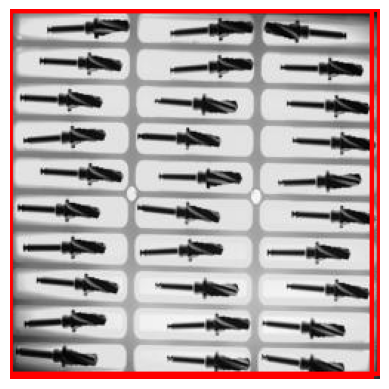

In [42]:
import cv2
import matplotlib.pyplot as plt

boxes = results[0].boxes

for box in boxes:
    x1, y1, x2, y2 = box.xyxy[0]
    label = f'{results[0].names[53]}'  # 53 is the class ID for 'pizza'
    color = (255, 0, 0)
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    cv2.putText(image, label, (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.imshow(image)
plt.axis('off')
plt.show()


###Faster R-CNN

In [47]:
# 필요한 패키지와 Protobuf 설치
# !apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
# !pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools

E: Unable to locate package python-pil
E: Unable to locate package python-lxml


In [48]:
# TensorFlow Models Repository 클론
# !git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 97132, done.
remote: Counting objects: 100% (412/412), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 97132 (delta 233), reused 361 (delta 212), pack-reused 96720
Receiving objects: 100% (97132/97132), 611.14 MiB | 19.02 MiB/s, done.
Resolving deltas: 100% (70651/70651), done.


In [49]:
# Protobuf 컴파일
# %cd models/research/
# !protoc object_detection/protos/*.proto --python_out=.

/content/models/research


In [50]:
# Object Detection API 설치
# !cp object_detection/packages/tf2/setup.py .
# !python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [51]:
# 환경 변수 설정
import os
import sys
sys.path.append("/content/drive/My Drive/Faster-RCNN_TF-master")

In [52]:
# API가 올바르게 설치되었는지 테스트
# models/research 디렉토리에서 실행
# !python object_detection/builders/model_builder_tf2_test.py

Traceback (most recent call last):
  File "/content/models/research/object_detection/builders/model_builder_tf2_test.py", line 24, in <module>
    from object_detection.builders import model_builder
  File "/usr/local/lib/python3.10/dist-packages/object_detection/builders/model_builder.py", line 26, in <module>
    from object_detection.builders import hyperparams_builder
  File "/usr/local/lib/python3.10/dist-packages/object_detection/builders/hyperparams_builder.py", line 27, in <module>
    from object_detection.core import freezable_sync_batch_norm
  File "/usr/local/lib/python3.10/dist-packages/object_detection/core/freezable_sync_batch_norm.py", line 20, in <module>
    class FreezableSyncBatchNorm(tf.keras.layers.experimental.SyncBatchNormalization
AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'


In [58]:
import os
import pathlib

import numpy as np
import tensorflow as tf

from object_detection.utils import visualization_utils as vis_util

In [57]:
# 모델 로드
model_dir = '/content/drive/My Drive/Faster-RCNN_TF-master'
detection_model = tf.saved_model.load(str(model_dir))

# 이미지 로드
def load_image_into_numpy_array(path):
    return np.array(pathlib.Path(path).read_bytes())

image_path = '/content/drive/My Drive/NewCountTrayImg/372.jpg'
image_np = load_image_into_numpy_array(image_path)
input_tensor = tf.convert_to_tensor(image_np)[tf.newaxis, ...]

# 감지 수행
detections = detection_model(input_tensor)

# 클래스 매핑 (레이블 맵 대신에 클래스 이름을 직접 정의)
category_index = {1: {'id': 1, 'name': 'person'},
                  2: {'id': 2, 'name': 'bicycle'},
                  3: {'id': 3, 'name': 'car'},
                  4: {'id' : 4, 'name' : 'tray'}
                  # 나머지 클래스들도 필요에 따라 추가
                 }

# 결과 시각화
def visualize_detections(image_np, detections, category_index):
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.3,
        agnostic_mode=False)
    return image_np

image_np_with_detections = visualize_detections(image_np.copy(), detections, category_index)

# 시각화된 이미지 출력
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(image_np_with_detections)
plt.show()

OSError: SavedModel file does not exist at: /content/drive/My Drive/Faster-RCNN_TF-master/{saved_model.pbtxt|saved_model.pb}